##구글 드라이브를 마운트 하고 install된 패키지들이 저장된 개인 경로를 설정합니다.

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
my_path = '/content/notebooks'
os.symlink('/content/drive/MyDrive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

베이스라인의 아래 다운로드 구문은 미리 경로에 다운로드 해두었기 때문에 생략합니다.

! apt-get install -y openjdk-8-jdk python3-dev

! pip install konlpy "tweepy<4.0.0"

! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

! pip install transformers

##필요한 패키지들을 import해줍니다.(베이스라인에서 나뉘어져있던 import구문들을 정리해 모아두었습니다.

In [ ]:
import os
import random
import math
import csv
import json
from tqdm.notebook import tqdm
from easydict import EasyDict as edict
from statistics import mean
from typing import List, Tuple, Dict, Any

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import wandb

import torch
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F



from transformers import ElectraModel, ElectraTokenizer, ElectraForQuestionAnswering, AutoModelForQuestionAnswering, AutoTokenizer

##wandb와 model의 config에 들어갈 argument들을 EasyDict로 정의해 접근하기 쉽게 선언합니다.

EasyDict? - https://koreapy.tistory.com/m/756

In [ ]:
args = edict({'wandb_project': 'dongil_test_MRC',
              'wandb_entity': 'goorm_nlp_project_1',
              'learning_rate': 5e-5,
              'batch_size': {'train': 16,
                             'eval': 16,
                             'test': 256},
              'accumulate': 8,
              'epochs': 5,
              'seed': 42,
              'model_name': 'monologg/kobigbird-bert-base',
              'max_length': 2048})
args['name'] = ''f'kobigbird_epoch-{args.epochs}_lr_sche_wd'
print(args.name)

kobigbird_epoch-5_lr_sche_wd


##wnadb에 로그인 및 init을 시행하고 wandb에 들어갈 config를 정의해줍니다.

In [ ]:
wandb.login()

True

In [ ]:
wandb.init(project = args.wandb_project, entity = args.wandb_entity, reinit=True)

In [ ]:
wandb.run.name = args.name
wandb.config.learning_rate = args.learning_rate
wandb.config.epochs = args.epochs
wandb.config.batch_size = args.batch_size

##모델에 사용될 여러 random값들의 seed를 고정하여 선언해줍니다.

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

###Baseline에 주어진 Dataset을 가져와 사용할수 있는 class를 구성합니다.

In [ ]:
class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices


    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)


    # 데이터 셋을 잘라내는 메소드 sklearn의 train_test_split과 같은 역할.
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1, seed=42):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)


    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        qa = paragraph['qas'][q_id]

        guid = qa['guid']

        context = paragraph['context'].replace('\n', 'n').replace('\xad', '')
        

        question = qa['question'].replace('\n', 'n').replace('\xad', '')

        answers = qa['answers']
        if answers != None:
            for a in answers:
                a['text'] = a['text'].replace('\n', 'n').replace('\xad', '')


        return {'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)

In [ ]:
dataset = KoMRC.load('/content/drive/MyDrive/goorm/goorm-project-2-korean_mrc/data/train.json')
train_dataset, dev_dataset = KoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))


Number of Samples: 12037
Number of Train Samples: 10834
Number of Dev Samples: 1203


In [ ]:
def dev2csv(dataset = dev_dataset, long_short = -1):
  with open("../content/dev.csv", 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = [[sample['guid'], sample['answers'][long_short]['text']] for sample in dataset ]
    
    writer.writerows(rows)

In [ ]:
dev2csv()

###모델의 토크나이저를 불러옵니다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name)

Downloading:   0%|          | 0.00/373 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/169 [00:00<?, ?B/s]

##위에서 설정한 KoMRC클래스에서의 데이터를 토크나이징합니다.

In [ ]:
class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tokenizer = tokenizer


    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []

        sentence_tokens = []
        for word in sentence.split():
            if '[UNK]' in tokenizer.tokenize(word):
                sentence_tokens.append(word)
            else:
                sentence_tokens += tokenizer.tokenize(word)
        '''
        토크나이저로 토크나이징을 하게되면 단어의 뒷부분에 들어오는 형태소?의 경우 앞에 ##이 붙게된다
        ex) iteration -> iter, ##ration 이런느낌?
        일반적인 경우에는 상관없지만 현재 태스크의 경우 context 토큰들에서 정답에 대한 start index와
        end index를 가져와 index로 접근을 해야하는데 ##을 지워주지 않으면 index에 영향을 끼치므로 지워준다.
        '''
        for morph in sentence_tokens:
            if len(morph) > 2:
                if morph[:2] == '##':
                    morph = morph[2:]

            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)
            
        return tokens
            

    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)
        # sample = {'guid': guid, 'context': context, 'question': question, 'answers': answers}

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)

        question = self._tokenizer.tokenize(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print(context, answer)
                    print(answer['guid'])
                    print(answer['answer_start'])
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print(context, answer)
                    print(answer['guid'])
                    print(answer['answer_start'])
                    raise ValueError("No Matched end position")

                answers.append({'start': start, 'end': end})
                
        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers
        }

In [ ]:
dataset = TokenizedKoMRC.load('/content/drive/MyDrive/goorm/goorm-project-2-korean_mrc/data/train.json')
train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))


Number of Samples: 12037
Number of Train Samples: 10834
Number of Dev Samples: 1203


In [ ]:
print(dev_dataset[0])

{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context_original': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작

In [ ]:
sample = dev_dataset[0]
print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])

['서강대', '메리', '홀', '대', '극장']


##Indexer 선언

In [ ]:
class Indexer:
    def __init__(self, vocabs: List[str], max_length: int=args.max_length):
        self.max_length = max_length
        self.vocabs = vocabs
    #vocabs = 기존 baseline 코드에서 자체적으로 마든 Dataset의 id2token 대신 tokenizer의 vacab을 들고오기 위해 변경.
    '''
    self.id2token = self.special_tokens + id2token
    self.token2id = {token: token_id for token_id, token in enumerate(self.id2token)}
    Baseline에선 자체적으로 Vocab을 구성하고 모델에 쓰일 스페셜 토큰([pad], [unk],[cls],[sep])을 추가하여
    self.token2id 메소드를 통해 각 토큰들을 dict형태로 저장해 토크나이징을 진행했다면
    해당 코드에서는 tokenizer의 vocab을 사용할 것이기 때문에 별도의 추가 메소드 없이
    property를 이용해 각 스페셜 토큰들과 vocab의 총 길이만 반환 가능하게 구성한다.

    '''
    @property
    def vocab_size(self):
        return len(self.vocabs)
    @property
    def pad_id(self):
        return tokenizer.vocab['[PAD]']
    @property
    def unk_id(self):
        return tokenizer.vocab['[UNK]']
    @property
    def cls_id(self):
        return tokenizer.vocab['[CLS]']
    @property
    def sep_id(self):
        return tokenizer.vocab['[SEP]']

    '''
    위에 설명한 이유로 아래의 vocab을 생성하고 decode하는 메소드 부분은 사용하지 않는다.

    @classmethod
    def build_vocab(cls, dataset: TokenizedKoMRC, min_freq: int=5):
        counter = Counter(chain.from_iterable(
            sample['context'] + sample['question']
            for sample in tqdm(dataset, desc="Counting Vocab")
        ))

        return cls([word for word, count in counter.items() if count >= min_freq])
    
    def decode(self, token_ids: Sequence[int]):
        return [self.id2token[token_id] for token_id in token_ids]
    '''

    def sample2ids(self, sample: Dict[str, Any],) -> Dict[str, Any]:
        context = [tokenizer.convert_tokens_to_ids(token) for token in sample['context']]
        question = [tokenizer.convert_tokens_to_ids(token) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(len(question) + 2 + answer['start'], self.max_length - 1)
            end = min(len(question) + 2 + answer['end'], self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [ ]:
indexer = Indexer(list(tokenizer.vocab.keys()))
print(indexer.sample2ids(dev_dataset[0]))

{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람

In [ ]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample

In [ ]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
print('input_ids', sample['input_ids'])
print('attention_mask', sample['attention_mask'])
print('token_type_ids', sample['token_type_ids'])
print('start', sample['start'])
print('end', sample['end'])
print('guid', sample['guid'])

input_ids [2, 3715, 4853, 4606, 7066, 4771, 8409, 4837, 8911, 4544, 28322, 7373, 4604, 4222, 4741, 8100, 4741, 7294, 4627, 4771, 535, 3, 6935, 7284, 8911, 3398, 3723, 9048, 9072, 2901, 3429, 8631, 7113, 3729, 3652, 3295, 3621, 11448, 28322, 7734, 3128, 2554, 2856, 2873, 518, 7343, 3632, 2657, 2889, 3398, 7657, 606, 7734, 7340, 3398, 516, 8356, 3632, 2657, 3398, 7113, 606, 19953, 606, 7657, 3398, 2968, 3723, 7854, 4224, 700, 8440, 7665, 26718, 701, 512, 7041, 598, 6797, 3732, 6891, 3094, 8634, 4016, 7340, 9210, 2889, 9210, 516, 7074, 3732, 598, 525, 3694, 6884, 3732, 3417, 2603, 2930, 8404, 2657, 2876, 9536, 4325, 3752, 3232, 4270, 9210, 513, 516, 8911, 2889, 3398, 6786, 6950, 2618, 19953, 3398, 3723, 3246, 3722, 700, 6969, 2542, 3839, 1, 701, 512, 6917, 3732, 598, 525, 3694, 7243, 3732, 6891, 3094, 28246, 3448, 9210, 513, 516, 8911, 2889, 3398, 7113, 606, 8409, 3398, 2618, 11340, 3633, 3632, 2657, 3398, 7854, 3744, 3731, 700, 10082, 3681, 701, 512, 525, 3694, 529, 598, 6917, 3732, 1996

##DataLoader에 들어갈 Collate_fn 정의

In [ ]:
class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer


    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {key: [sample[key] for sample in samples] for key in samples[0]}

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence([torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                                        batch_first=True,
                                        padding_value=self._indexer.pad_id)

        return samples

##DataLoader에 데이터 올리기

In [ ]:
collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset,
                          batch_size = args.batch_size.train // args.accumulate,
                          shuffle = True,
                          collate_fn = collator,
                          num_workers = 2)

dev_loader = DataLoader(indexed_dev_dataset,
                        batch_size = args.batch_size.eval,
                        shuffle = False,
                        collate_fn = collator,
                        num_workers = 2)

In [ ]:
batch = next(iter(dev_loader))
print(batch['input_ids'])
print(batch['input_ids'].shape)
print(list(batch.keys()))

tensor([[    2,  3715,  4853,  ...,     0,     0,     0],
        [    2,  7222,  8235,  ...,     0,     0,     0],
        [    2,  4224,  7769,  ...,     0,     0,     0],
        ...,
        [    2,   522,  5161,  ...,     0,     0,     0],
        [    2,  3926,  4559,  ...,     0,     0,     0],
        [    2,  3635, 26334,  ...,     0,     0,     0]])
torch.Size([16, 896])
['guid', 'context', 'question', 'position', 'input_ids', 'token_type_ids', 'start', 'end', 'attention_mask']


##모델 다운로드

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)

Downloading:   0%|          | 0.00/870 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'bert.pooler.bias', 'bert.pooler.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

##디바이스 및 옵티마이저 설정

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=0.5)

In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.9 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

##모델 학습

In [ ]:
train_losses = []
dev_losses = []

train_loss = []
dev_loss = []

loss_accumulate = 0.

best_model = [-1, int(1e9)]

for epoch in range(args.epochs):
    print("Epoch", epoch, '===============================================================================================================')

    # Train    
    progress_bar_train = tqdm(train_loader, desc='Train')
    for i, batch in enumerate(progress_bar_train, 1):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.cuda() for key, value in batch.items()}
        
        start = batch.pop('start')
        end = batch.pop('end')
        
        output = model(**batch)

        start_logits = output.start_logits
        end_logits = output.end_logits
        
        loss = (F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)) / args.accumulate
        loss.backward()

        loss_accumulate += loss.item()

        del batch, start, end, start_logits, end_logits, loss
        
        if i % args.accumulate == 0:
            # clip_grad_norm_(model.parameters(), max_norm=1.)
            optimizer.step()
            optimizer.zero_grad(set_to_none=False)

            train_loss.append(loss_accumulate)
            progress_bar_train.set_description(f"Train - Loss: {loss_accumulate:.3f}")
            loss_accumulate = 0.
        else:
            continue

        if i % int(len(train_loader) / (args.accumulate * 25)) == 0:
            # Evaluation
            for batch in dev_loader:
                del batch['guid'], batch['context'], batch['question'], batch['position']
                batch = {key: value.cuda() for key, value in batch.items()}

                start = batch.pop('start')
                end = batch.pop('end')
                
                model.eval()
                with torch.no_grad():
                    output = model(**batch)
                
                    start_logits = output.start_logits
                    end_logits = output.end_logits
                model.train()

                loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

                dev_loss.append(loss.item())

                del batch, start, end, start_logits, end_logits, loss

            train_losses.append(mean(train_loss))
            dev_losses.append(mean(dev_loss))
            train_loss = []
            dev_loss = []

            
            if dev_losses[-1] <= best_model[1]:
                best_model = (epoch, dev_losses[-1])
                model.save_pretrained(f'models/{args.name}_{epoch}')
                # print(f'model saved!!\nvalid_loss: {dev_losses[-1]}')
                
            wandb.log({"train_loss": train_losses[-1],
                       "valid_loss": dev_losses[-1]})
            

    print(f"Train Loss: {train_losses[-1]:.3f}")
    print(f"Valid Loss: {dev_losses[-1]:.3f}")
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    scheduler.step()

Epoch 0 ===============================================================================================================


Train:   0%|          | 0/5417 [00:00<?, ?it/s]

RuntimeError: ignored

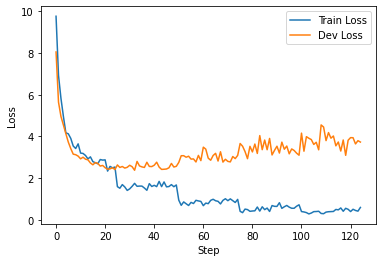

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(dev_losses, label="Dev Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
wandb.finish()

train_loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂▂▂▂▂▃▂▃▂▂▂▃▄▃▂▃▃▃
train_loss,0.59643
valid_loss,3.72894


In [ ]:
test_dataset = TokenizedKoMRC.load('/content/drive/MyDrive/goorm/goorm-project-2-korean_mrc/data/test.json')
indexer_test = Indexer(list(tokenizer.vocab.keys()))
indexed_test_dataset = IndexerWrappedDataset(test_dataset, indexer_test)
print("Number of Test Samples", len(test_dataset))
# print(test_dataset[0])

Number of Test Samples 4008


In [ ]:
best_model[0]

1

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(f'models/{args.name}_{best_model[0]}')
model.cuda();

In [ ]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]

    print('Answer:', sample['context'][start_str:end_str])

------1------
Context: 1조3000억원에 달하는 사기성 기업어음(CP)을 발행해 투자자들에게 손해를 끼친 혐의 등으로 기소된 현재현 동양그룹 회장(65·사진)에게 징역 12년형이 선고됐다. 이는 역대 형사재판에 넘겨진 재벌 총수 중 두 번째로 무거운 형이다.서울중앙지법 형사합의25부(부장판사 위현석)는 17일 오후 열린 현 회장에 대한 선고 공판에서 “피해자가 4만명에 달하고 피해 금액도 유례를 찾아보기 힘든 대규모 기업범죄로 엄중한 책임을 묻지 않을 수 없다”며 이같이 선고했다. 함께 기소된 정진석 전 동양증권 사장은 징역 5년을, 김철 전 동양네트웍스 대표와 이상화 전 동양인터내셔널 대표는 각각 징역 4년과 3년6월을 선고받았다. 검찰은 앞서 현 회장에게 징역 15년형을 구형했다.재판부는 현 회장에게 적용된 1조2985억원의 사기성 CP 등 발행 혐의와 141억원대 횡령 혐의를 유죄로 판단했다. 재판부는 “피고인들은 CP 발행 당시 자력으로 만기상환하는 것은 불가능하다는 점을 알고 있었다”며 “현 회장은 그룹의 지배구조에 집착한 나머지 일반투자자를 상대로 기망적 수단과 방법을 동원해 CP와 회사채를 발행했다”고 지적했다. 이어 “이로 인해 경영과 아무런 관계가 없는 다수의 피해자가 막대한 경제적·정신적 피해를 입었다”며 “범행을 부인하며 반성하지 않고, 피해 회복을 위한 노력도 하지 않아 중형을 선고하지 않을 수 없다”고 말했다. 다만 시세조종 혐의와 6000억원대 배임 혐의에 대해서는 일부 유죄로, 회계 부정과 허위 재무제표 공시 혐의는 무죄로 판단했다.현 회장이 받은 징역 12년형은 역대 형사재판에 넘겨진 재벌 총수 중 두 번째로 높은 형이다. 최고형은 1997년 한보사태 때 정태수 전 한보그룹 회장이 받은 징역 15년형이다.
Question: 재벌총수 중 지금까지 가장 높은 형량을 받은 사람의 이름은?
Answer: 정태수
------2------
Context: 제닉스 스튜디오(대표 이일희)는 블록체인 기반 IoT 플랫폼 ‘젠서(x

In [ ]:
start_visualize = []
end_visualize = []

with torch.no_grad(), open('../content/drive/MyDrive/goorm/goorm-project-2-korean_mrc/data/submission_kobigbird_wd.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    c = 0
    for sample in tqdm(indexed_test_dataset, "Testing"):
    #for sample in tqdm(two_indexed_dev_dataset, "Testing"):
        input_ids, token_type_ids = [torch.tensor(sample[key], dtype=torch.long, device="cuda") for key in ("input_ids", "token_type_ids")]
        # print(sample)
    
        model.eval()
        with torch.no_grad():
            output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

        start_logits = output.start_logits
        end_logits = output.end_logits
        start_logits.squeeze_(0), end_logits.squeeze_(0)

        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

        # 토큰 길이 8까지만
        for row in range(len(start_prob) - 8):
            probability[row] = torch.cat((probability[row][:8+row].cpu(), torch.Tensor([0] * (len(start_prob)-(8+row))).cpu()), 0)

        index = torch.argmax(probability).item()

        start = index // len(end_prob)
        end = index % len(end_prob)
        
        # 시작점과 끝점의 확률이 각각 0.3보다 낮으면 출력을 하지 않는다.
        if start_prob[start] > 0.3 and end_prob[end] > 0.3:
            start_str = sample['position'][start][0]
            end_str = sample['position'][end][1]
        else:
            start_str = 0
            end_str = 0

        start_visualize.append((list(start_prob.cpu()), (start, end), (start_str, end_str)))
        end_visualize.append((list(end_prob.cpu()), (start, end), (start_str, end_str)))
        
        rows.append([sample["guid"], sample['context'][start_str:end_str]])

    writer.writerows(rows)

Testing:   0%|          | 0/4008 [00:00<?, ?it/s]

In [ ]:
def levenshtein(s1, s2):
    # s2가 s1보다 길면 반대로 돌려서 계산
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    
    # s2의 길이가 0 이면 모두 추가 
    if len(s2) == 0:
        return len(s1)

    # base 행 : [0,1,2...s2]
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1): # s1에서 글자 하나씩 빼옴
        current_row = [i + 1] # 0~i 길이만큼 deletion이 일어났을 때의 비용
        for j, c2 in enumerate(s2): # s2에서 글자 하나씩 빼옴
            # 비용 계산
            insertions = previous_row[j + 1] + 1 
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))

        previous_row = current_row

    # s1 과 s2 끝부분끼리 비교부분 리턴
    return previous_row[-1]

In [ ]:
import pandas as pd
def return2distance(data1 = "dev.csv", data2 = "baseline.csv"):
    try:
        df1 = pd.read_csv(data1, encoding = 'utf-8')
        df2 = pd.read_csv(data2, encoding = 'utf-8')
    except FileNotFoundError as e: 
        dev2csv(dev_dataset)

    diff = []

    for s1, s2 in zip(df1['Predicted'], df2['Predicted']):
        if type(s1) == float : s1=""
        if type(s2) == float :
            s2 = ""
    
        diff.append(levenshtein(s1, s2))

    return sum(diff) / len(diff)

In [ ]:
return2distance('dev.csv', 'dev_dataset_pred_2.csv')

164.14463840399003

In [ ]:
two_indexed_dev_dataset = IndexerWrappedDataset(two_dev_dataset, indexer)

In [ ]:
dev2csv(dataset=imsi_dev_dataset)

In [ ]:
return2distance('dev.csv', 'dev_dataset_pred.csv')

2.1213632585203657

In [ ]:
return2distance('submission_kobigbird_v1.csv', 'submission_kobigbird_wd.csv')

1.4006986027944113